In [1]:
import os
if os.name != 'posix':
    %matplotlib ipympl
else:
    %matplotlib notebook
import scipy.constants as sc
from scipy.optimize import fsolve

import numpy as np
import cmath
import matplotlib.pyplot as plt
import scipy.constants as sc
plt.rcParams.update({
    "text.usetex": True,
    'text.latex.preamble': r"\usepackage{amsmath} \boldmath"
})
import os
import h5py

print(os.getpid())
%cd ../../

import pylib.mix as mix

11780
C:\Users\ivan9\Documents\work\codes\QuCF\scripts-py


In [9]:
# --- Launch to change cells' width ---
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

colors_ = ["blue", "red", "green", "gray", "black"]

from matplotlib import ticker
cmap_two_signs_= 'coolwarm'
cmap_two_signs_= 'Blues'
# cmap_two_signs_= 'Greys'
# cmap_two_signs_= 'Pastel1'
# cmap_two_signs_= 'flag'
# cmap_two_signs_= 'nipy_spectral'
# cmap_two_signs_= 'jet'
# cmap_two_signs_= 'seismic'
def fmt_(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

path_save_ = "./jupyter-notebooks/NL/results/"

In [38]:
# ---------------------------------------------------------------------------------------------------
# --- Prepare intial parameters ---
# ---------------------------------------------------------------------------------------------------
nx, nt = 7, 9
Nx = 1<<nx
Nt = 1<<nt
x = np.linspace(-2,2,Nx)
t = np.linspace(0,4,Nt)
dx = np.diff(x)[0]
dt = np.diff(t)[0]

psi_init_ = np.zeros(Nx, dtype=float)

delta_gauss = 0.05
x_center = 1.0
coef_gauss = 1./(np.sqrt(2.*np.pi) * delta_gauss)
for ii in range(Nx):
    psi_init_[ii] = np.exp(-(x[ii] - x_center)**2/(2.*delta_gauss**2))
psi_init_ = np.sqrt(coef_gauss * psi_init_)
psi_init_[0] = 0
psi_init_[Nx-1] = 0
del ii

print("sum psi**2: {:0.3e}".format(np.trapz(psi_init_**2, dx=dx)))

sum psi**2: 1.000e+00


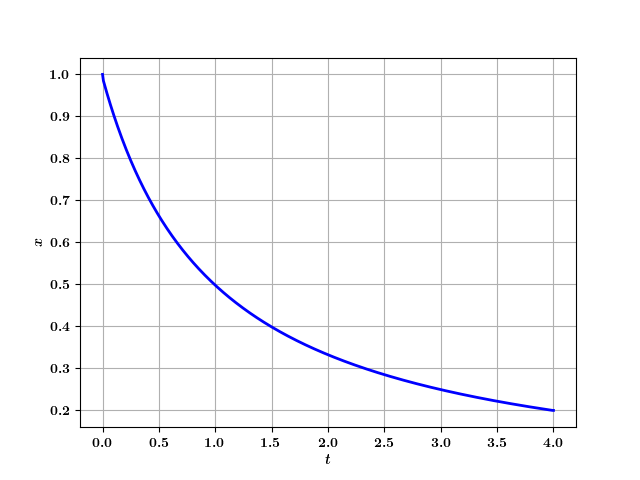

In [39]:
# -----------------------------------------------------------------
# --- Solve d x / d t = - x**2: standart method (for reference) ---
# -----------------------------------------------------------------
from scipy.integrate import RK45
mix.reload_module(mix)

oo = RK45(
    lambda t,x: -x**2, 
    t[0], 
    [x_center], t[-1], first_step=dt, max_step=dt
)

sol_ref = np.zeros(Nt, dtype=float)
sol_ref[0] = x_center
Nt_act = 1

oo.step()
oo.t
while mix.compare_two_strings(oo.status, "running"):
    oo.step()
    Nt_act += 1
    if Nt_act - 1 == Nt:
        print(oo.t)
    sol_ref[Nt_act-1] = float(oo.y[0])
    
plt.close()
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(t, sol_ref, color='b', linewidth = 2, linestyle='-')
plt.xlabel('$t$')
plt.ylabel("$x$")
plt.grid(True)
plt.show()

In [40]:
# -----------------------------------------------------------------------------------------------------
# --- FUNCTIONS for the construction and analysis of KvN matrix ---
# * an eigenvalue is degenerate if there are several eigenvectors that correspond to this eigenvalue
# -----------------------------------------------------------------------------------------------------
from scipy.linalg import eig
mix.reload_module(mix)

# ---------------------------------------------------------------------------
def is_Hermitian(A, name):
    inds_nonzero = np.nonzero(np.transpose(np.conjugate(A)) - A)
    if np.size(inds_nonzero) == 0:
        print("the matrix {:s} is Hermitian".format(name))
    else:
        print("the matrix {:s} is non-Hermitian".format(name))
    return
    
# ---------------------------------------------------------------------------
def find_equal_eigenvalues(
    eigvs, 
    abs_prec = 1e-12, 
    flag_print_values=False
):
    equal_values = {
        "eigv": [], 
        "n": [],    # multiplicity
        "inds": []
    }

    for ii in range(Nx-1):
        v1 = eigvs[ii]
        n_equal = 1
        inds = [ii]
        for kk in range(ii+1, Nx):
            if mix.compare_complex_values(v1, eigvs[kk], prec = abs_prec):
                n_equal += 1
                inds.append(kk)
        if  n_equal > 1:
            equal_values["eigv"].append(v1)
            equal_values["n"].append(n_equal)
            equal_values["inds"].append(inds)

    # maximum multiplicity:
    max_n = np.max(equal_values["n"])
    ids_max_n = np.where(equal_values["n"] == max_n)[0]

    print("number of degenerate eigenvalues: {:d}".format(len(equal_values["eigv"])))
    print("maximum multiplicity of degenerate eigenvalues: {:d}".format(max_n))

    # print("\nindices of degenerate eigenvalues:")
    # print(equal_values["inds"])

    if flag_print_values:
        mix.print_numbered_array(equal_values["eigv"], ff=[35, 9, "e"], n_in_row = 4)
    
    return equal_values, max_n, ids_max_n

# ---------------------------------------------------------------------------
def compute_eigv(A, name, abs_prec = 1e-12, flag_print_equal_eigv=False):
    is_Hermitian(A, name)
    eig_values, eig_vectors = eig(A)
    dict_equl_eigv, max_mult, ids_max_mult = find_equal_eigenvalues(eig_values, abs_prec = abs_prec, flag_print_values = flag_print_equal_eigv)
    props = [name, eig_values, eig_vectors, dict_equl_eigv, max_mult, ids_max_mult, abs_prec]
    return props

# ---------------------------------------------------------------------------
def analyse_matrix(
    props,
    flag_plot_eigenvalues = True,
    flag_plot_eigenvectors = True,
    ind_eigv = None,
    flag_save = False
):
    name, eig_values, eig_vectors, dict_equl_eigv, max_mult, ids_max_mult, abs_prec = props
    if flag_plot_eigenvalues:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(np.array(range(len(eig_values))), eig_values.imag, "or",label="imag")
        ax.plot(np.array(range(len(eig_values))), eig_values.real, "*b",label="real")
        plt.xlabel("$i$")
        plt.ylabel("$\lambda_i$")
        plt.title("eigenvalues for the matrix {:s}".format(name))
        ax.legend()
        plt.grid(True)
        plt.show()

    if flag_save:
        mix.save_dat_plot_1d_file(
            path_save_ + "/" + name + "_eigvalues_real.dat",    
            np.array(range(len(eig_values))), 
            eig_values.real
        )
        mix.save_dat_plot_1d_file(
            path_save_ + "/" + name + "_eigvalues_imag.dat",    
            np.array(range(len(eig_values))), 
            eig_values.imag
        )
        print()
        
    if flag_plot_eigenvectors:
        if ind_eigv is None:
            print("ERROR: indicate for which eigenvalue one should plot eigenfunctions.")
            return
        plot_eigenvectors_for_deg_eigvalue(dict_equl_eigv, ind_eigv, eig_vectors, eig_values)
    return

# ---------------------------------------------------------------------------
def plot_eigenvectors_for_deg_eigvalue(dict_equl_eigv, ind_eigv, eig_vectors, eig_values):
    eigv = dict_equl_eigv["eigv"][ind_eigv]
    n_mult = dict_equl_eigv["n"][ind_eigv]
    inds_for_chosen_eigvs = dict_equl_eigv["inds"][ind_eigv]

    print("plot eigefunctions for eigenvalue = {:21.3e}".format(eigv))
    
    # --- real ---
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for ii in range(n_mult):
        i_plot = inds_for_chosen_eigvs[ii]
        eig_function = eig_vectors[i_plot]
        print("recheck: ind, eigenvalue: {:d}, {:21.9e}".format(i_plot, eig_values[i_plot]))
        ax.plot(x, eig_function.real, color = colors_[ii], linewidth = 2, linestyle='-', label="{:d}".format(i_plot))
    plt.xlabel("$x$")
    plt.ylabel("real: eigenfunction")
    plt.title("eigefunctions for EIGV={:21.3f}: real part".format(eigv))
    # ax.legend()
    plt.grid(True)
    plt.show()

    # --- imag ---
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for ii in range(n_mult):
        i_plot = inds_for_chosen_eigvs[ii]
        eig_function = eig_vectors[i_plot]
        ax.plot(x, eig_function.imag, color = colors_[ii], linewidth = 2, linestyle='-', label="{:d}".format(i_plot))
    plt.xlabel("$x$")
    plt.ylabel("imag: eigenfunction")
    plt.title("eigefunctions for EIGV={:21.3f}: imag part".format(eigv))
    # ax.legend()
    plt.grid(True)
    plt.show()
    return

# ---------------------------------------------------------------------------
def construct_CD_matrix():
    A_CD = np.zeros((Nx, Nx), dtype=complex)
    for ii in range(1,Nx-1):
        Fm = - x[ii-1]**2
        Fc = - x[ii]**2
        Fp = - x[ii+1]**2
        A_CD[ii,ii-1] = - (Fm + Fc)
        A_CD[ii,ii+1] =   (Fp + Fc)
    A_CD = -1j/(4.*dx) * A_CD
    A_CD[1,0] = 0.0
    A_CD[Nx-2, Nx-1] = 0.0

    # A_CD[0,0] = 1.0
    # A_CD[Nx-1, Nx-1] = 1.0
    return A_CD

# ---------------------------------------------------------------------------
def construct_UW_matrix():
    A_UW = np.zeros((Nx, Nx), dtype=complex)
    for ii in range(1,Nx-1):
        Fc = - x[ii]**2
        Fp = - x[ii+1]**2
        A_UW[ii,ii] = - 2 * Fc
        A_UW[ii,ii+1] = Fp + Fc
    A_UW = -1j/(2.*dx) * A_UW
    A_UW[Nx-2, Nx-1] = 0.0

    # A_UW[0,0] = 1.0
    # A_UW[Nx-1, Nx-1] = 1.0
    return A_UW

In [41]:
# -----------------------------------------------------------------------------------------------------
# --- CONSTRUCT the KvN matrix ---
# * an eigenvalue is degenerate if there are several eigenvectors that correspond to this eigenvalue
# -----------------------------------------------------------------------------------------------------
mix.reload_module(mix)

# ---------------------------------------------------------------------------
print("--- CENTRAL DIFFERENCE SCHEME ---")
A_CD     = construct_CD_matrix()
props_CD = compute_eigv(A_CD, "CD", abs_prec = 1e-12, flag_print_equal_eigv=False)

print("\n\n--- UPWINDING DIFFERENCE SCHEME ---")
A_UW     = construct_UW_matrix()
props_UW = compute_eigv(A_UW, "UW", abs_prec = 1e-12, flag_print_equal_eigv=False)

--- CENTRAL DIFFERENCE SCHEME ---
the matrix CD is Hermitian
number of degenerate eigenvalues: 55
maximum multiplicity of degenerate eigenvalues: 2


--- UPWINDING DIFFERENCE SCHEME ---
the matrix UW is non-Hermitian
number of degenerate eigenvalues: 64
maximum multiplicity of degenerate eigenvalues: 2


In [42]:
for _ in range(30):
    plt.close()

--- UPWINDING DIFFERENCE SCHEME ---


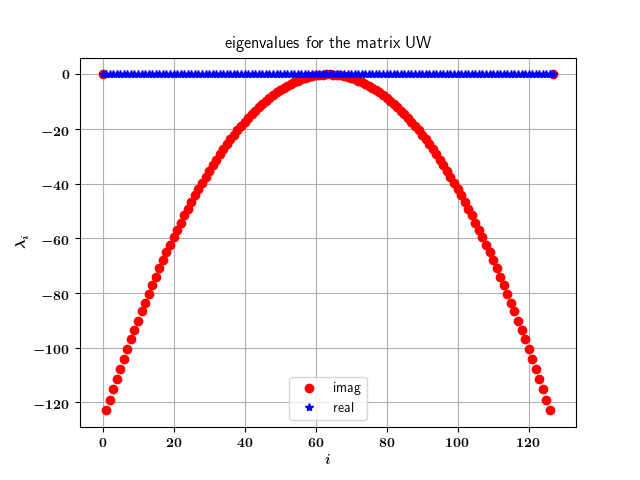

write data to a file: ./jupyter-notebooks/NL/results//UW_eigvalues_real.dat
write data to a file: ./jupyter-notebooks/NL/results//UW_eigvalues_imag.dat

plot eigefunctions for eigenvalue =  0.000e+00-1.153e+02j
recheck: ind, eigenvalue: 3, 0.000000000e+00-1.152834646e+02j
recheck: ind, eigenvalue: 124, 0.000000000e+00-1.152834646e+02j


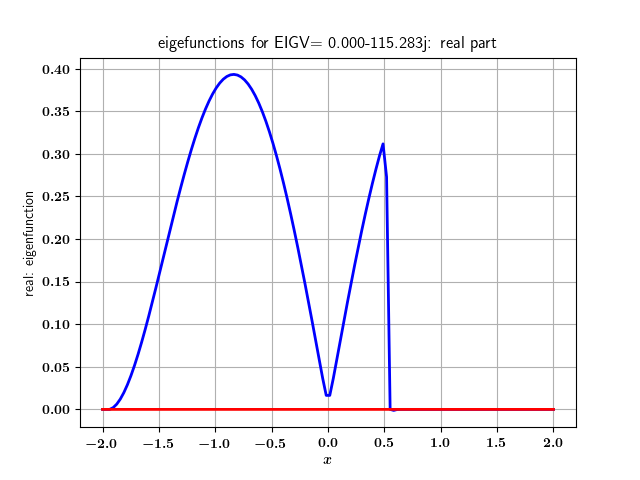

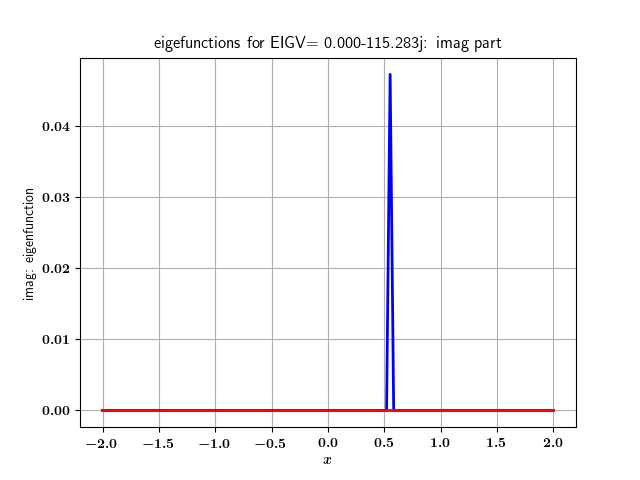

In [43]:
# --------------------------------------------------------------
# --- ANALYSE matrices ---
# --------------------------------------------------------------
mix.reload_module(mix)

# print("--- CENTRAL DIFFERENCE SCHEME ---")
# analyse_matrix(
#     props_CD,
#     flag_plot_eigenvalues = True,
#     flag_plot_eigenvectors = True,
#     ind_eigv = 10,
#     flag_save = True
# )

print("--- UPWINDING DIFFERENCE SCHEME ---")
analyse_matrix(
    props_UW,
    flag_plot_eigenvalues = True,
    flag_plot_eigenvectors = True,
    ind_eigv = 3,
    flag_save = True
)

In [47]:
# --------------------------------------------------------------------------------
# --- Solve the system by using the matrix ---
# --------------------------------------------------------------------------------
from numba import njit
import time

# -------------------------------------------------
def solve_using_matrix(A, psi_tx):
    coef_dt = dt * (-1j)
    for it in range(Nt-1):
        Hpsi = A.dot(psi_tx[it])

        for ix in range(1, Nx-1):
            psi_tx[it+1, ix] = psi_tx[it, ix] + coef_dt * Hpsi[ix]

# -------------------------------------------------
psi_tx_matrix = np.zeros((Nt,Nx), dtype = complex)
psi_tx_matrix[0,:] = np.array(psi_init_)

# simulation:
st = time.time()

solve_using_matrix(A_CD, psi_tx_matrix)
# solve_using_matrix(A_UW, psi_tx_matrix)

et = time.time()
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

Execution time: 0.09217286109924316 seconds


In [48]:
# ---------------------------------------------------------------------------------------------------
# --- Compute mean value ---
# ---------------------------------------------------------------------------------------------------
x_operator = np.diag(x)

mean_t = np.zeros(Nt)
for it in range(Nt):
    psi_t1   = psi_tx_matrix[it,:]
    psi_t1_c = np.conjugate(psi_t1)
    
    # mean_t[it] = psi_t1_c.dot(x*psi_t1)
    # mean_t[it] = psi_t1_c.dot(x_operator.dot(psi_t1)) * dx
    norm = psi_t1_c.dot(psi_t1) * dx
    mean_t[it] = np.trapz(x*psi_t1_c*psi_t1, dx=dx) / norm

C:\Users\ivan9\AppData\Local\Temp\ipykernel_11780\958719444.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  mean_t[it] = np.trapz(x*psi_t1_c*psi_t1, dx=dx) / norm


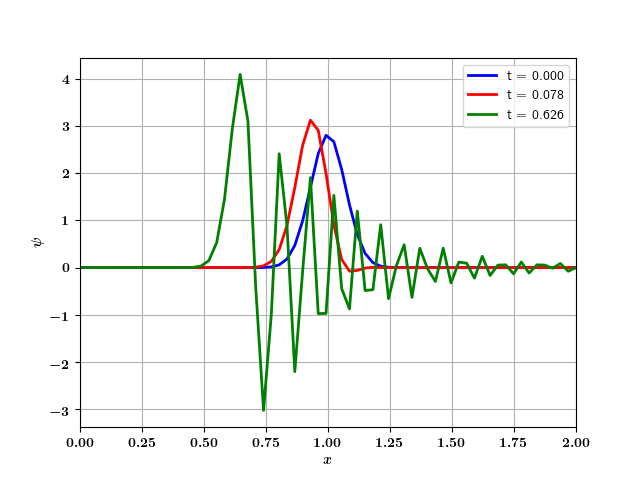

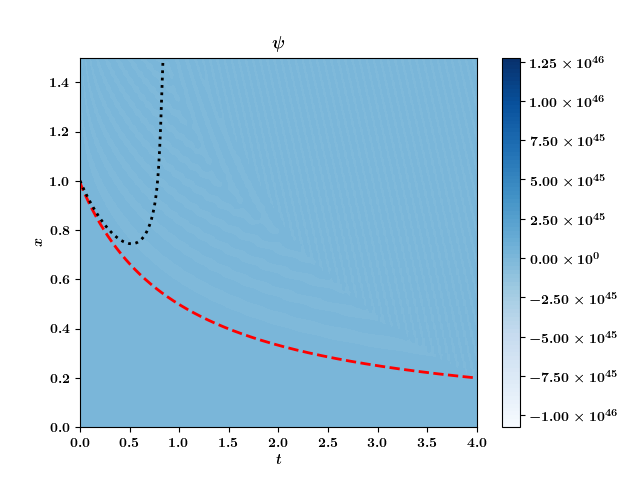

In [62]:
# ---------------------------------------------------------------------------------------------------
# --- Print psi_tx_matrix(t,x) ---
# ---------------------------------------------------------------------------------------------------
XX, YY = np.meshgrid(t, x)

fig_tx = plt.figure()
ax = fig_tx.add_subplot(111)
cs = ax.contourf(XX, YY, np.transpose(psi_tx_matrix.real), levels=100, cmap=cmap_two_signs_)
fig_tx.colorbar(cs, ax = ax, format=ticker.FuncFormatter(fmt_))
ax.plot(t, sol_ref, color='r', linewidth = 2, linestyle='--')
ax.plot(t, mean_t, color='black', linewidth = 2, linestyle=':')
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_title('$\psi$')
ax.set_ylim(0.0, 1.5)

# ---------------------------------------------------------------------------------------------------
# --- Print psi(x) at different t ---
# ---------------------------------------------------------------------------------------------------
t_moments = [10, 80] 

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, psi_tx_matrix.real[0,:], color='b', linewidth = 2, linestyle='-', label="t = {:0.3f}".format(t[0]))

counter = 0
for it_ind in t_moments:
    counter += 1
    ax.plot(x, psi_tx_matrix.real[it_ind,:], color=colors_[counter], linewidth = 2, linestyle='-', label="t = {:0.3f}".format(t[it_ind]))
    # ax.axvline(mean_t[it_ind], ymin = ax.get_ylim()[0], ymax = ax.get_ylim()[1], color = 'gray', linewidth = 2, linestyle = "--")
del counter

# ax.plot(x, psi_tx_matrix.real[-1,:], color='r', linewidth = 2, linestyle='--')
# ax.axvline(sol_ref[-1], ymin = ax.get_ylim()[0], ymax = ax.get_ylim()[1], color = 'gray', linewidth = 2, linestyle = "-")

plt.xlim([0,2])

plt.xlabel('$x$')
plt.ylabel("$\psi$")
ax.legend()
plt.grid(True)
plt.show()